In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image

# Specify the path of the folder containing the images
folder_path = '/content/drive/MyDrive/Hematoxylin-Brown-Score/raw-images'

# Create a new folder to save the resized images
resized_folder = os.path.join(folder_path, 'resized')
os.makedirs(resized_folder, exist_ok=True)

# Iterate through all the images in the folder
for filename in os.listdir(folder_path):
    # If the file is an image file
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        im = Image.open(os.path.join(folder_path, filename))
        # Resize the image
        im_resized = im.resize((30, 30))
        # Save the resized image to the new folder
        im_resized.save(os.path.join(resized_folder, filename))


In [3]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.utils as image
from sklearn.cluster import KMeans
import numpy as np
import os

# Load the VGGNet model
model = VGG16(weights='imagenet', include_top=False)

# Specify the path of the folder containing the images
folder_path = '/content/drive/MyDrive/Hematoxylin-Brown-Score/raw-images/resized'

# Initialize an empty list to store the feature vectors
feature_vectors = []

# Iterate through all the images in the folder
for filename in os.listdir(folder_path):
    # If the file is an image file
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        img = image.load_img(os.path.join(folder_path, filename), target_size=(50, 50))
        # Preprocess the image for the VGGNet model
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract the feature vector from the image using the VGGNet model
        feature_vector = model.predict(x).flatten()
        # Append the feature vector to the list
        feature_vectors.append(feature_vector)

# Convert the list of feature vectors to a numpy array
feature_vectors = np.array(feature_vectors)

# Perform K-means clustering on the feature vectors
kmeans = KMeans(n_clusters=3, random_state=0).fit(feature_vectors)

# Print the cluster labels for each image
print(kmeans.labels_)

1/1 [==============================] - 0s 27ms/step
[0 0 0 ... 2 0 0]


In [4]:
import csv

# Create a dictionary to store the image names and their cluster labels
image_labels = {}

# Iterate through all the images in the folder
i = 0
for filename in os.listdir(folder_path):
    # If the file is an image file
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Get the image name and the corresponding cluster label
        image_name = filename
        cluster_label = kmeans.labels_[i]
        # Add the image name and cluster label to the dictionary
        image_labels[image_name] = cluster_label
        i += 1

# Create a CSV file and write the image names and cluster labels to it
with open('/content/drive/MyDrive/Hematoxylin-Brown-Score/results/image_clusters3.csv', 'w', newline='') as csvfile:
    fieldnames = ['Image', 'Cluster Label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for image_name, cluster_label in image_labels.items():
        writer.writerow({'Image': image_name, 'Cluster Label': cluster_label})



In [5]:
from PIL import Image

# Specify the path of the folder containing the images
folder_path = '/content/drive/MyDrive/Hematoxylin-Brown-Score/raw-images/resized'

# Initialize an empty list to store the image paths
image_paths = []

# Iterate through all the images in the folder
for filename in os.listdir(folder_path):
    # If the file is an image file
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Append the image path to the list
        image_paths.append(os.path.join(folder_path, filename))

# Convert the list of image paths to a numpy array
image_paths = np.array(image_paths)

# Iterate through all the clusters
for i in range(3):
    # Get the indices of all images in the current cluster
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    # Get the image paths for the images in the current cluster
    cluster_image_paths = image_paths[cluster_indices]
    # Print the number of images in the current cluster
    print(f"Number of images in cluster {i}: {len(cluster_image_paths)}")
    # Display a few images from the current cluster



Number of images in cluster 0: 1649
Number of images in cluster 1: 446
Number of images in cluster 2: 499


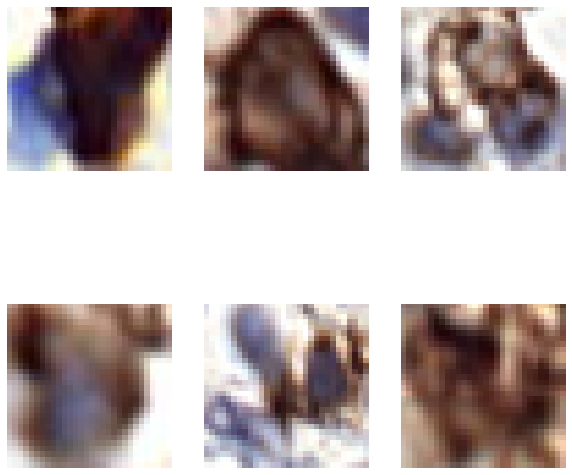

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(10, 10))
for j, ax in enumerate(axs.flat):
    im = Image.open(cluster_image_paths[j])
    ax.imshow(im)
    ax.axis('off')
plt.show()


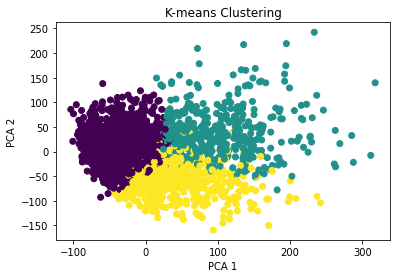

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA for visualization purposes
pca = PCA(n_components=2)
feature_vectors_pca = pca.fit_transform(feature_vectors)

# Create a scatter plot of the feature vectors with different colors for each cluster
plt.scatter(feature_vectors_pca[:, 0], feature_vectors_pca[:, 1], c=kmeans.labels_)
plt.title("K-means Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

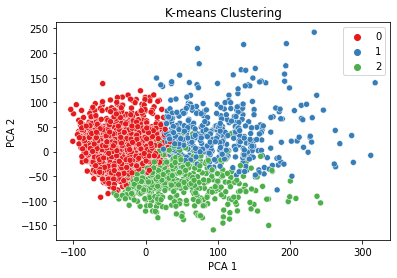

In [8]:
import seaborn as sns

# Perform PCA for visualization purposes
pca = PCA(n_components=2)
feature_vectors_pca = pca.fit_transform(feature_vectors)

# Create a scatter plot of the feature vectors with different colors for each cluster
sns.scatterplot(x=feature_vectors_pca[:, 0], y=feature_vectors_pca[:, 1], hue=kmeans.labels_,palette='Set1',legend='full')
plt.title("K-means Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

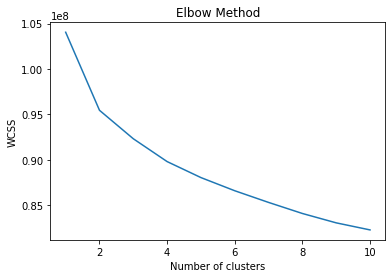

In [9]:
from sklearn.cluster import KMeans

# Create a list to store the WCSS (within cluster sum of squares) values for each number of clusters
wcss = []

# Fit K-means for a range of number of clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(feature_vectors)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values for each number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
